# Training KN models with tensorflow

## Imports

In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# NMMA imports
import nmma
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS
from nmma.em.training import SVDTrainingModel

# Tensorflow imports 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
        }

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Install wrapt_timeout_decorator if you want timeout simulations.


2023-12-12 22:34:13.354000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 22:34:13.467292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 22:34:14.017136: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: ~/MultiNest/lib/
2023-12-12 22:34:14.017218: W tensorflow/compiler/xla/stream_executor/

## Preliminaries

In [2]:
# Choose model and set location of the kilonova lightcurves
bulla_2022_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2022"
bulla_2019_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2019"

# Choose the model here
# model_name = "Bu2022Ye"
model_name = "Bu2019lm"
model_function = MODEL_FUNCTIONS[model_name]

# Set the location of the lightcurves and outdir based on chosen model
if model_name == "Bu2022Ye":
    lcs_dir = bulla_2022_dir
    
elif model_name == "Bu2019lm":
    lcs_dir = bulla_2019_dir

outdir = f"/home/urash/twouters/new_nmma_models/"

# Process the KN lightcurves
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

print("Reading lightcurves and interpolating NaNs...")
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))

print("Original filters:")
print(filts)

print("Reading lightcurves and interpolating NaNs... DONE")

# Limit to the filters of interest for the KN event that Peter is interested in:
if model_name == "Bu2022Ye":
    filts = ["ztfg", "ztfi", "ztfr"] # limited for now for Peter's KN event
else:
    filts = [f for f in filts if "sdss" in f]

print("Filters:")
print(filts)

# Get the time array
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
t = dat["t"].values

print("Genrating training data...")
training_data, parameters = model_function(data)
print("Genrating training data... DONE")

print("Getting SVD model")
svd_ncoeff = 10
training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="tensorflow",
        svd_path=outdir,
        start_training=False, # don't train, just prep the data
        load_model=False, # don't load a model, just prep the data
    )
print("Getting SVD model DONE")

print("Generating SVD model")
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model
print("Generating SVD model DONE")

There are 1596 lightcurves for this model.
Reading lightcurves and interpolating NaNs...
Original filters:
['bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'cspk', 'sdss__g', 'sdss__i', 'sdss__r', 'sdss__u', 'sdss__z', 'swope2__H', 'swope2__J', 'swope2__y', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white']
Reading lightcurves and interpolating NaNs... DONE
Filters:
['sdss__g', 'sdss__i', 'sdss__r', 'sdss__u', 'sdss__z']
Genrating training data...
Genrating training data... DONE
Getting SVD model
The grid will be interpolated to sample_time with interp1d
Not loading new model
Getting SVD model DONE
Generating SVD model
Normalizing mag filter sdss__g...
Normalizing mag filter sdss__i...
Normalizing mag filter sdss__r...
Normalizing mag filter sdss__u...
Normalizing mag filter sdss__z...
Generating SVD model DONE


In [3]:
# sanity check
parameters

['log10_mej_dyn', 'log10_mej_wind', 'KNphi', 'KNtheta']

## Training TF model

Define LR scheduler

In [11]:
def lr_schedule(epoch, current_lr, nb_epochs=80, multiplier=0.25):
    if epoch == 0:
        return current_lr
    elif epoch % nb_epochs == 0:
        return current_lr * multiplier
    else:
        return current_lr
    
lr_scheduler = LearningRateScheduler(lr_schedule)

In [12]:
training_history_list = []

for i, f in enumerate(filts):
    
    print(f"============================================================================================================")
    print(f"Training {f} filter ({i+1}/{len(filts)})")

    X = training_model.svd_model[f]['param_array_postprocess'] # complete dataset of input data of network
    n_samples, input_ndim = X.shape
    print(f"Features (input) have shape {X.shape}")

    y = training_model.svd_model[f]['cAmat'].T
    _, output_ndim = y.shape
    print(f"Labels (output) have shape {y.shape}")
    
    # Perform train-validation split
    train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=0)
    
    model = Sequential()
    model.add(
        Dense(
            128,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            256,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            256,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(
        Dense(
            128,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(train_X.shape[1],),
        )
    )
    model.add(Dense(training_model.n_coeff))

    # # Show the architecture:
    # model.summary()
    
    model.compile(optimizer="adam", loss="mse")
    n_epochs = 200

    # fit the model
    training_history = model.fit(
        train_X,
        train_y,
        epochs=n_epochs,
        batch_size=32,
        validation_data=(val_X, val_y),
        callbacks=[lr_scheduler], 
        verbose=True,
    )
    
    training_model.svd_model[f]["model"] = model
    training_history_list.append(training_history)

Training sdss__g filter (1/5)
Features (input) have shape (1596, 4)
Labels (output) have shape (1596, 10)
Epoch 1/200
45/45 [==============================] - 2s 8ms/step - loss: 0.2645 - val_loss: 0.0847 - lr: 0.0010
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0751 - val_loss: 0.0703 - lr: 0.0010
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0688 - val_loss: 0.0601 - lr: 0.0010
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0518 - val_loss: 0.0433 - lr: 0.0010
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0434 - val_loss: 0.0339 - lr: 0.0010
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0311 - val_loss: 0.0253 - lr: 0.0010
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0219 - val_loss: 0.0175 - lr: 0.0010
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0125 - lr: 0.001

### Training history to check for overfitting

Final training loss sdss__g: 0.0010645176516845822
Final validation loss sdss__g: 0.002302516018971801


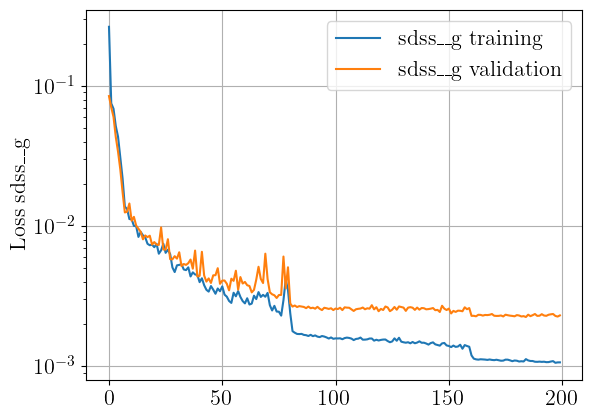

Final training loss sdss__i: 0.0019355315016582608
Final validation loss sdss__i: 0.004061989951878786


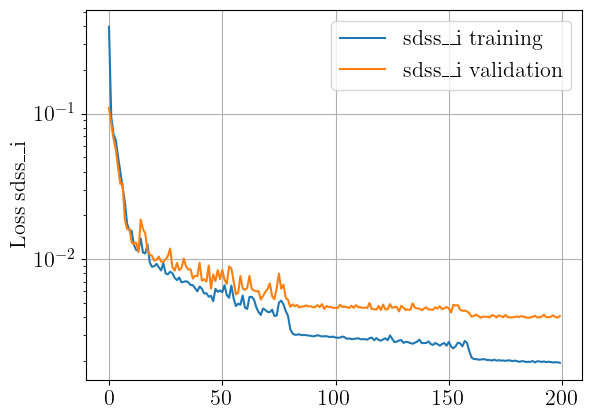

Final training loss sdss__r: 0.0016740249702706933
Final validation loss sdss__r: 0.0034289793111383915


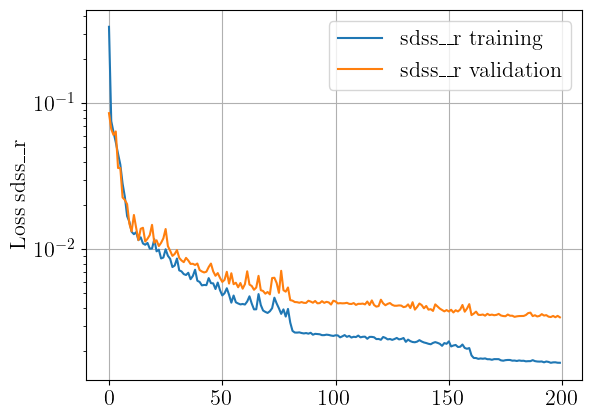

Final training loss sdss__u: 0.00114832550752908
Final validation loss sdss__u: 0.0020434062462300062


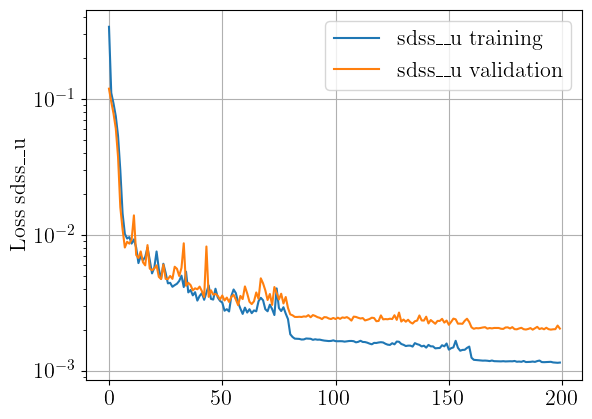

Final training loss sdss__z: 0.0006867750198580325
Final validation loss sdss__z: 0.001733441255055368


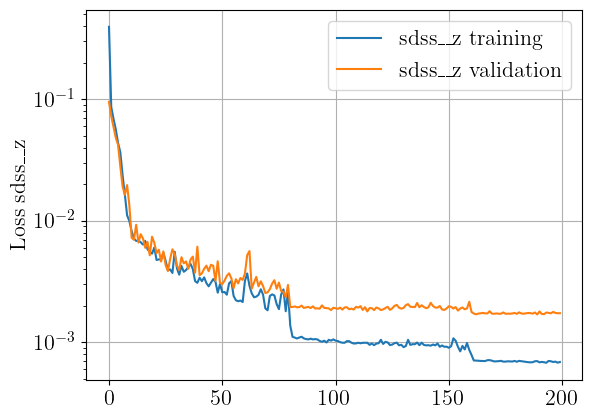

In [13]:
for filt, history in zip(filts, training_history_list):
    # Print the final loss values for training and validation
    print(f"Final training loss {filt}: {history.history['loss'][-1]}")
    print(f"Final validation loss {filt}: {history.history['val_loss'][-1]}")
        
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label=f"{filt} training")
    plt.plot(history.history['val_loss'], label=f"{filt} validation")
    plt.yscale("log")
    plt.ylabel(f"Loss {filt}")
    plt.legend()
    plt.show()
    plt.close()

## Check output on a lightcurve (as sanity check for comparison notebook)

We will load the model for simplicity

In [14]:
from nmma.em.model import SVDLightCurveModel

lc_model = SVDLightCurveModel(
        model_name,
        t,
        svd_path=outdir,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="tensorflow",
        model_parameters=None,
        filters=filts,
        local_only=True
)

Loaded filter sdss__g
Loaded filter sdss__i
Loaded filter sdss__r
Loaded filter sdss__u
Loaded filter sdss__z


Load the model again (some bug in the code)

In [15]:
# Get the normalized parameters of the first lightcurve of our dataset
idx = 0

print("Example parameters for input in surrogate model:")
key = list(training_data.keys())[idx]
example_parameters = [training_data[key][param] for param in parameters]
example_parameters = np.array(example_parameters)
print(example_parameters)

# Get the magnitude of this filter
_, _, mAB = nmma.em.utils.calc_lc(t,
                                example_parameters, 
                                svd_mag_model = lc_model.svd_mag_model, 
                                interpolation_type="tensorflow", 
                                filters = filts, 
                                mag_ncoeff = 10
                                )

Example parameters for input in surrogate model:
[-3. -2.  0. 90.]


## Finally, save the model

In [16]:
training_model.save_model()